In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Define the directories for training and validation
train_data_dir = '/content/drive/MyDrive/SplitImages/train'
validation_data_dir = '/content/drive/MyDrive/SplitImages/validation'

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Define batch sizes and other parameters
batch_size_train = 16  # Smaller batch size for histological images
batch_size_val = 16
epochs = 100

# Data generators with augmentation and preprocessing suitable for histological images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input  # VGG19-specific preprocessing
)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(375, 375),  # Adjusted target size suitable for VGG19
    batch_size=batch_size_train,
    classes=['Non-Tumor', 'Viable'],
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(375, 375),
    batch_size=batch_size_val,
    classes=['Non-Tumor', 'Viable'],
    class_mode='binary'
)

# Load the VGG19 model with pre-trained weights and discard the top (fully connected) layers
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(375, 375, 3))

# Freeze most of the pre-trained layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_binary = Dense(1, activation='sigmoid')(x)

model_binary = Model(inputs=base_model.input, outputs=output_binary)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_binary.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_generator.classes)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Train the model
history = model_binary.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size_train,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size_val,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

# Print the classes used for binary classification
print("Classes used for binary classification:", train_generator.class_indices)


Found 579 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Epoch 1/100
36/36 [==============================] - 48s 710ms/step - loss: 0.2842 - accuracy: 0.8863 - val_loss: 0.2293 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 2/100
36/36 [==============================] - 31s 859ms/step - loss: 0.1425 - accuracy: 0.9609 - val_loss: 0.1505 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 3/100
36/36 [==============================] - 27s 740ms/step - loss: 0.1241 - accuracy: 0.9609 - val_loss: 0.1343 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 4/100
36/36 [==============================] - 30s 822ms/step - loss: 0.0825 - accuracy: 0.9734 - val_loss: 0.0859 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 5/100
36/36 [==============================] - 31s 870ms/step - loss: 0.0888 - accuracy: 0.9698 - val_loss: 0.0957 - val_accuracy: 0.9740 - lr: 1.0000e-04
Epoch 6/100
36/36 [==============================] - 27s 749ms/step - loss: 0.0929 - accuracy: 0.9698 - val_loss:

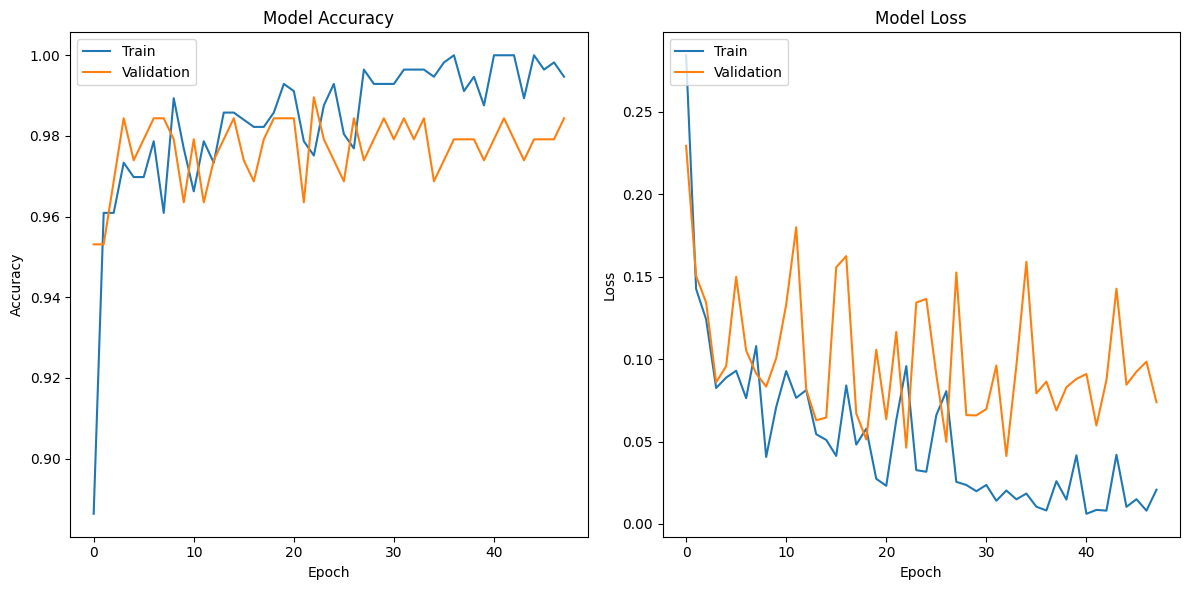

In [2]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [3]:
test_data_dir = '/content/drive/MyDrive/SplitImages/test'

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(375, 375),
    batch_size=batch_size_val,  # Use batch_size_val for testing
    classes=['Non-Tumor', 'Viable'],
    class_mode='binary'
)

# Evaluate the model on the test data
test_loss, test_accuracy = model_binary.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 51 images belonging to 2 classes.
4/4 [==============================] - 1s 160ms/step - loss: 0.0704 - accuracy: 0.9804
Test Loss: 0.07039022445678711
Test Accuracy: 0.9803921580314636


Found 51 images belonging to 2 classes.
4/4 [==============================] - 1s 198ms/step
Classification Report:
               precision    recall  f1-score   support

   Non-Tumor       0.97      1.00      0.99        33
      Viable       1.00      0.94      0.97        18

    accuracy                           0.98        51
   macro avg       0.99      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



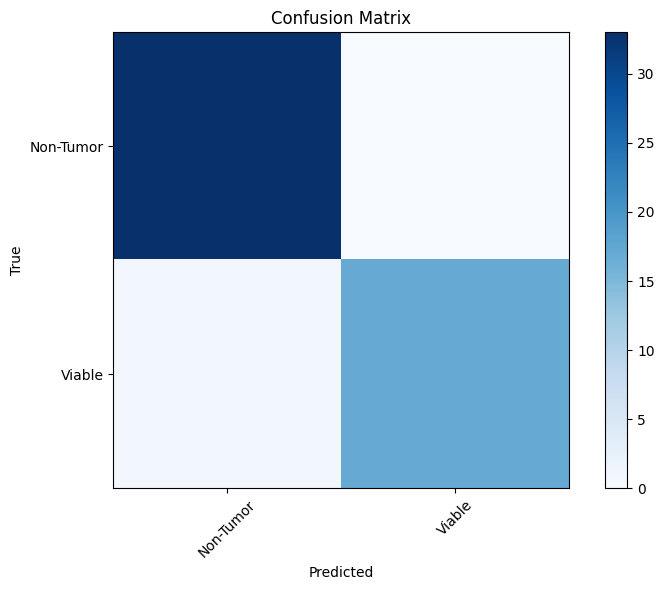

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the test data
test_data_dir = '/content/drive/MyDrive/SplitImages/test'

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(375, 375),
    batch_size=batch_size_val,
    classes=['Non-Tumor', 'Viable'],
    class_mode='binary',
    shuffle=False  # Keep the order of images
)

# Predict on the test data
test_predictions = model_binary.predict(test_generator)
test_predictions = np.round(test_predictions).flatten()

# Generate confusion matrix
cm = confusion_matrix(test_generator.classes, test_predictions)
class_names = test_generator.class_indices.keys()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# Print classification report
print("Classification Report:\n", classification_report(test_generator.classes, test_predictions, target_names=class_names))

plt.show()


1/1 [==============================] - 0s 43ms/step


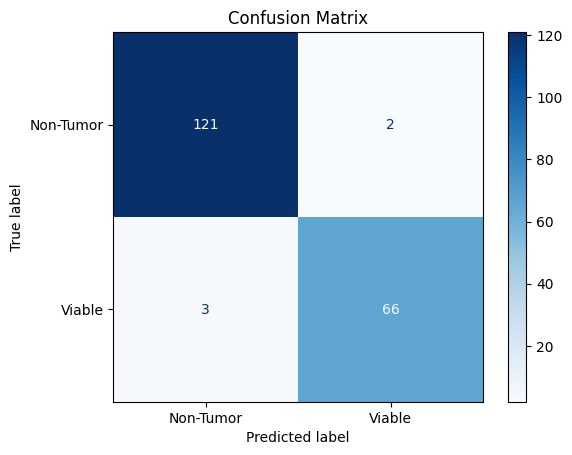

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict classes for validation data
validation_steps = validation_generator.samples // batch_size_val
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(y_val)
    y_pred.extend(model_binary.predict(x_val))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Tumor', 'Viable'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Layer Index: 1, Layer Name: block1_conv1
Layer Index: 2, Layer Name: block1_conv2
Layer Index: 4, Layer Name: block2_conv1
Layer Index: 5, Layer Name: block2_conv2
Layer Index: 7, Layer Name: block3_conv1
Layer Index: 8, Layer Name: block3_conv2
Layer Index: 9, Layer Name: block3_conv3
Layer Index: 10, Layer Name: block3_conv4
Layer Index: 12, Layer Name: block4_conv1
Layer Index: 13, Layer Name: block4_conv2
Layer Index: 14, Layer Name: block4_conv3
Layer Index: 15, Layer Name: block4_conv4
Layer Index: 17, Layer Name: block5_conv1
Layer Index: 18, Layer Name: block5_conv2
Layer Index: 19, Layer Name: block5_conv3
Layer Index: 20, Layer Name: block5_conv4


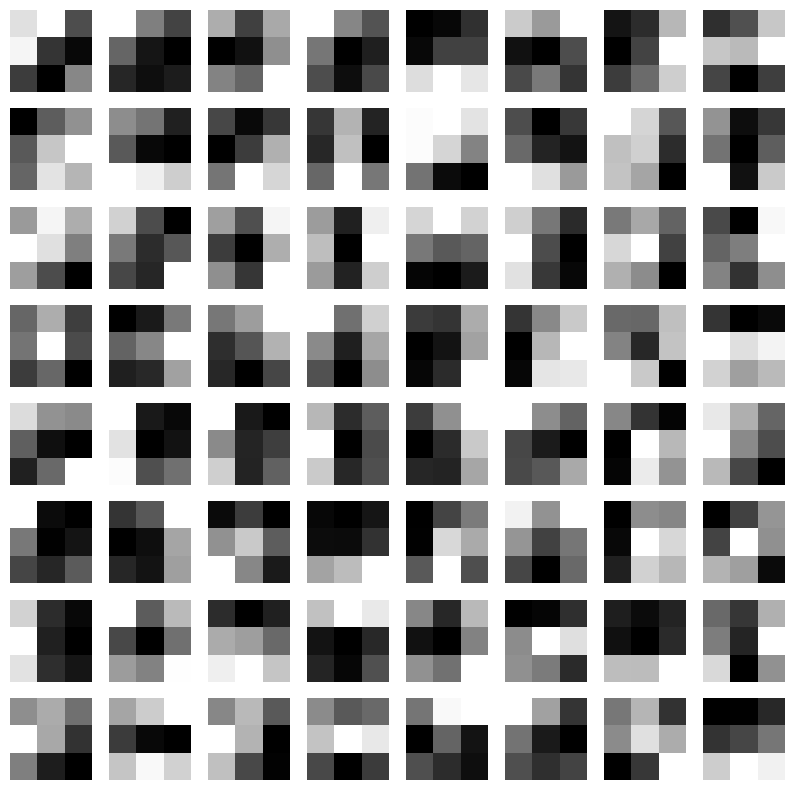

In [6]:
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

model_layers = model_binary.layers


for index, layer in enumerate(model_layers):

    if 'conv' in layer.name:
        print(f"Layer Index: {index}, Layer Name: {layer.name}")

index_of_conv_layer = 2  


conv_layer = model_binary.layers[index_of_conv_layer]


filters, biases = conv_layer.get_weights()

normalized_filters = (filters - filters.min()) / (filters.max() - filters.min())

number_of_filters = filters.shape[3]

sqrt_number_of_filters = int(number_of_filters**0.5)


plt.figure(figsize=(10, 10))

for i in range(number_of_filters):

    plt.subplot(sqrt_number_of_filters, sqrt_number_of_filters, i+1)

    plt.imshow(normalized_filters[:, :, 0, i], cmap='gray') 
    plt.axis('off')

plt.show()

1/1 [==============================] - 1s 741ms/step


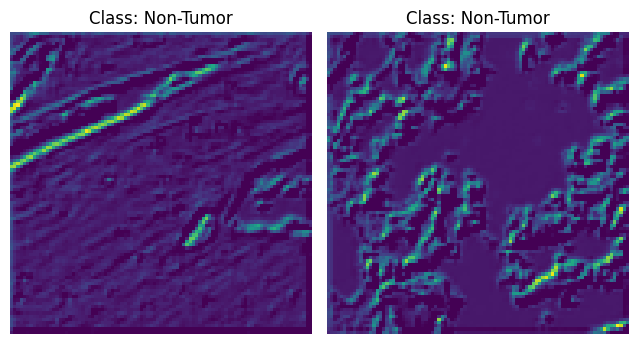

In [7]:
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

import numpy as np



# Define class names based on class indices

class_names = sorted(validation_generator.class_indices, key=lambda x: validation_generator.class_indices[x])



# Choose the layer to visualize (Dense layer with 1024 neurons)

layer_to_visualize = model_binary.layers[7]  # Assuming this is the index of the Dense layer



# Create a sub-model that outputs the activations of the chosen layer

activation_model = Model(inputs=model_binary.input, outputs=layer_to_visualize.output)



# Get activations for the chosen layer for a batch of images

num_samples = len(class_names)  # Number of different samples to visualize

num_neurons_to_visualize = 50



plt.figure(figsize=(16, 16 * num_samples))



for class_idx in range(num_samples):

    # Get a batch of images and labels from the validation generator for the current class

    sample_batch, sample_labels = validation_generator.next()

    activations = activation_model.predict(sample_batch)



    plt.subplot(num_samples, num_neurons_to_visualize // 10, class_idx + 1)



    for i in range(num_neurons_to_visualize):

        plt.imshow(activations[0, ..., i], cmap='viridis')

        plt.title(f"Class: {class_names[np.argmax(sample_labels[0])]}")

        plt.axis('off')



plt.tight_layout()

plt.show()

Layer Index: 1, Layer Name: block1_conv1
Layer Index: 2, Layer Name: block1_conv2
Layer Index: 4, Layer Name: block2_conv1
Layer Index: 5, Layer Name: block2_conv2
Layer Index: 7, Layer Name: block3_conv1
Layer Index: 8, Layer Name: block3_conv2
Layer Index: 9, Layer Name: block3_conv3
Layer Index: 10, Layer Name: block3_conv4
Layer Index: 12, Layer Name: block4_conv1
Layer Index: 13, Layer Name: block4_conv2
Layer Index: 14, Layer Name: block4_conv3
Layer Index: 15, Layer Name: block4_conv4
Layer Index: 17, Layer Name: block5_conv1
Layer Index: 18, Layer Name: block5_conv2
Layer Index: 19, Layer Name: block5_conv3
Layer Index: 20, Layer Name: block5_conv4


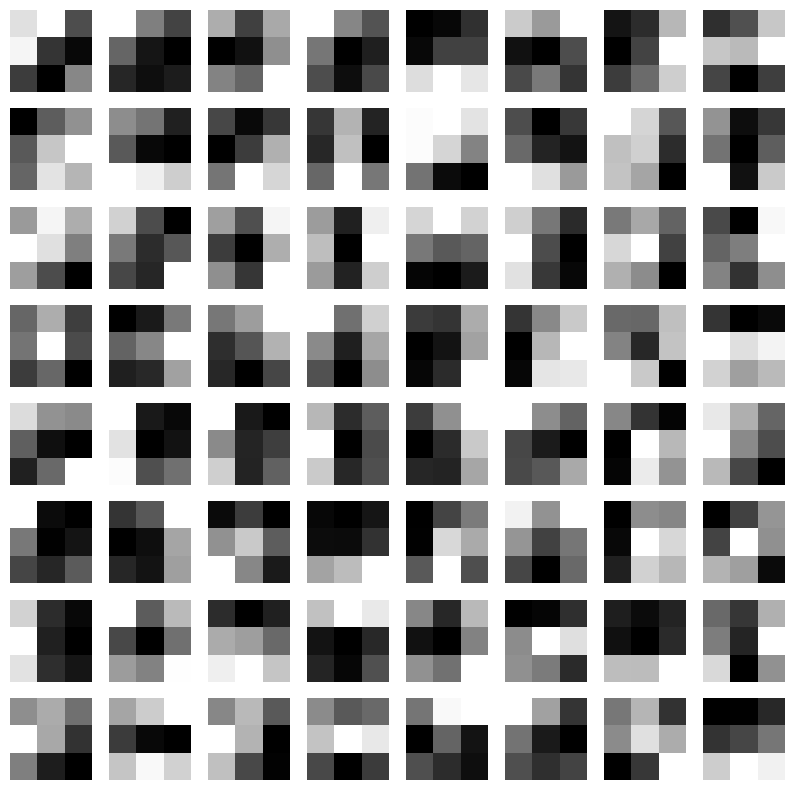

In [8]:
import matplotlib.pyplot as plt

# Get the list of layers in your model
model_layers = model_binary.layers

# Print the index and name of each layer to identify the convolutional layer
for index, layer in enumerate(model_layers):
    if 'conv' in layer.name:  # You can adjust this condition to identify the convolutional layers
        print(f"Layer Index: {index}, Layer Name: {layer.name}")

# Replace index_of_conv_layer with the actual index of the convolutional layer you want to visualize
index_of_conv_layer = 2  # Replace with the correct index

# Choose a convolutional layer to visualize
conv_layer = model_layers[index_of_conv_layer]

# Get the learned filters (kernels) for that layer
filters, biases = conv_layer.get_weights()

# Normalize the filters for visualization
normalized_filters = (filters - filters.min()) / (filters.max() - filters.min())

# Visualize the filters
number_of_filters = filters.shape[3]
sqrt_number_of_filters = int(number_of_filters**0.5)

plt.figure(figsize=(10, 10))

for i in range(number_of_filters):
    plt.subplot(sqrt_number_of_filters, sqrt_number_of_filters, i+1)
    plt.imshow(normalized_filters[:, :, 0, i], cmap='gray')  # Visualize only one channel of the filter
    plt.axis('off')

plt.show()


1/1 [==============================] - 1s 614ms/step


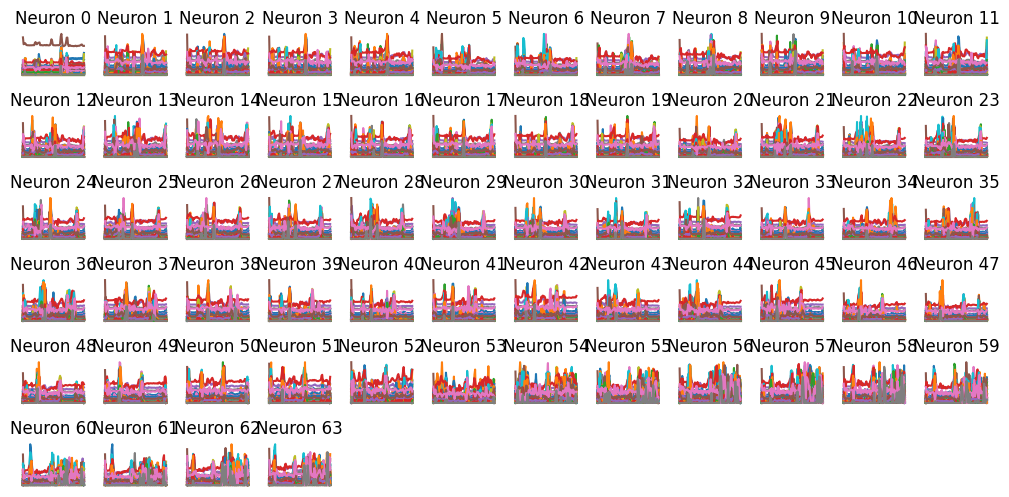

Class Names: ['Non-Tumor', 'Viable']


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Load the best model weights
model_binary = model_binary  # Replace with the actual path

# Create a new model that extracts the activations of the first dense layer
activation_model = Model(inputs=model_binary.input, outputs=model_binary.layers[6].output)

# Get the class indices from the generator
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Choose a random image batch from the validation generator
sample_batch = next(iter(validation_generator))
sample_images = sample_batch[0]

# Choose a random image index from the batch
image_index = np.random.randint(0, batch_size_val)

# Get the activations of the first dense layer for the selected image
activations = activation_model.predict(sample_images[image_index : image_index + 1])

# Determine the number of neurons in the layer
num_neurons = activations.shape[-1]

# Calculate the number of rows and columns for subplots
sqrt_num_neurons = int(np.ceil(np.sqrt(num_neurons)))

# Limit the number of neurons to visualize to a reasonable value
max_neurons_to_visualize = 64
num_neurons_to_visualize = min(max_neurons_to_visualize, num_neurons)

# Visualize the activations for each neuron
plt.figure(figsize=(10, 10))
for neuron_index in range(num_neurons_to_visualize):
    plt.subplot(sqrt_num_neurons, sqrt_num_neurons, neuron_index + 1)
    plt.plot(activations[0, neuron_index])
    plt.axis('off')
    plt.title(f'Neuron {neuron_index}')
plt.tight_layout()
plt.show()

# Print the class names
print("Class Names:", class_names)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model

# Load the best model weights
model_binary = model_binary

# Create a new model that extracts the activations of the first dense layer
activation_model = Model(inputs=model_binary.input, outputs=model_binary.layers[6].output)

# Get the class indices from the generator
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Get activations for the entire validation dataset
all_activations = []
all_labels = []

for batch in validation_generator:
    images, labels = batch
    activations = activation_model.predict(images)
    all_activations.append(activations)
    all_labels.append(labels)

    if len(all_activations) * batch_size_val >= validation_generator.samples:
        break

all_activations = np.concatenate(all_activations)
all_labels = np.concatenate(all_labels)

# Reshape the activations array for t-SNE
reshaped_activations = all_activations.reshape(all_activations.shape[0], -1)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
activations_tsne = tsne.fit_transform(reshaped_activations)

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
for class_idx, class_name in enumerate(class_names):
    indices = np.where(all_labels == class_idx)[0]
    plt.scatter(activations_tsne[indices, 0], activations_tsne[indices, 1], label=class_name)

plt.title("t-SNE Visualization of First Dense Layer Activations")
plt.legend()
plt.show()


1/1 [==============================] - 0s 48ms/step
